<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Image Augmentation

Image augmentation and test on image classification problems

Further readings:
* https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b


In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import sys
sys.path.append("../")
import numpy as np
from pathlib import Path

import fastai
from fastai.vision import *
from fastai.metrics import accuracy
import torch.cuda as cuda

from utils_ic.datasets import unzip_url, Urls
from utils_ic.fastai_utils import TrainMetricsRecorder
from utils_ic.gpu_utils import which_processor
from utils_ic.plot_utils import plot_pr_roc_curves, ResultsWidget


print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Cuda is not available. Fast.ai/Torch is using CPU


This shows your machine's GPUs (if has any) and which computing device fastai/torch is using. The output cells here show the run results on [Azure DSVM](https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/) Standard NC6.

1. We test on character images (MNIST)
2. Test on object images (our fridge dataset)

In [19]:
from tempfile import TemporaryDirectory

tmpdir = TemporaryDirectory()
fname = os.path.join(tmpdir.name, 'mnist.tgz')
# If this is too big, use TINY
path = untar_data(URLs.MNIST_SAMPLE, fname, tmpdir.name)
path.ls()

[PosixPath('/var/folders/51/dq28qy252kz2gcv53tj03r5h0000gn/T/tmp6c7f4hpz/mnist_sample/valid'),
 PosixPath('/var/folders/51/dq28qy252kz2gcv53tj03r5h0000gn/T/tmp6c7f4hpz/mnist_sample/labels.csv'),
 PosixPath('/var/folders/51/dq28qy252kz2gcv53tj03r5h0000gn/T/tmp6c7f4hpz/mnist_sample/train')]

In [20]:
tfms = get_transforms(do_flip=False)

In [21]:
data = (ImageList.from_folder(path)
        .split_by_folder()
        .label_from_folder()
        .transform(tfms, size=64)
        .databunch())
data

ImageDataBunch;

Train: LabelList (12396 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
7,7,7,7,7
Path: /var/folders/51/dq28qy252kz2gcv53tj03r5h0000gn/T/tmp6c7f4hpz/mnist_sample;

Valid: LabelList (2038 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
7,7,7,7,7
Path: /var/folders/51/dq28qy252kz2gcv53tj03r5h0000gn/T/tmp6c7f4hpz/mnist_sample;

Test: None

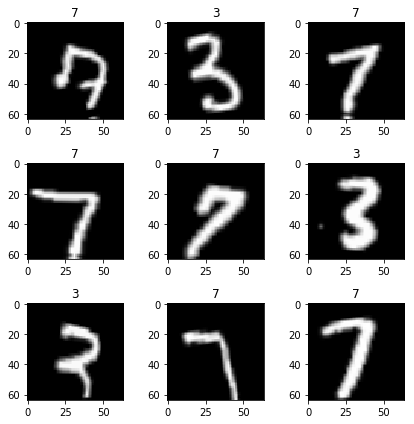

In [22]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [23]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy])
learn.fit_one_cycle(1,1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/jun/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 16219323.47it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.081400,0.025472,0.991659,04:36


In [25]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {100*float(metric):3.2f}')

Accuracy on validation set: 99.17


Set some parameters. We'll use the `unzip_url` helper function to download and unzip our data.

In [ ]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 299
BATCH_SIZE    = 16
ARCHITECTURE  = models.resnet50

---

## 1. Prepare Image Classification Dataset

In this notebook, we'll use a toy dataset called *Fridge Objects*, which consists of 134 images of can, carton, milk bottle and water bottle photos taken with different backgrounds. With our helper function, the data set will be downloaded and unzip to `image_classification/data`.

Let's set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [ ]:
path = Path(DATA_PATH)
path.ls()

You'll notice that we have four different folders inside:
- `/water_bottle`
- `/milk_bottle`
- `/carton`
- `/can`

The most common data format for multiclass image classification is to have a folder titled the label with the images inside:

```
/images
+-- can (class 1)
|   +-- image1.jpg
|   +-- image2.jpg
|   +-- ...
+-- carton (class 2)
|   +-- image31.jpg
|   +-- image32.jpg
|   +-- ...
+-- ...
```

and our data is already structured in that format!

## 2. Load Images

To use fastai, we want to create `ImageDataBunch` so that the library can easily use multiple images (mini-batches) during training time. We create an ImageDataBunch by using fastai's [data_block apis](https://docs.fast.ai/data_block.html).

For training and validation, we randomly split the data by 8:2, where 80% of the data is for training and the rest for validation. 

In [ ]:
data = (ImageList.from_folder(path) 
        .split_by_rand_pct(valid_pct=0.2, seed=10) 
        .label_from_folder() 
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE) 
        .normalize(imagenet_stats))

Lets take a look at our data using the databunch we created.

In [ ]:
data.show_batch(rows=3, figsize=(15,11))

Lets see all available classes:

In [ ]:
print(f'number of classes: {data.c}')
print(data.classes)

We can also see how many images we have in our training and validation set.

In [ ]:
data.batch_stats

In this notebook, we don't use test set. You can add it by using [add_test](https://docs.fast.ai/data_block.html#LabelLists.add_test). Please note that in the **fastai** framework, test datasets have no labels - this is the unknown data to be predicted. If you want to validate your model on a test dataset with labels, you probably need to use it as a validation set.

## 3. Train a Model

For the model, we use a convolutional neural network (CNN). Specifically, we'll use **ResNet50** architecture. You can find more details about ResNet from [here](https://arxiv.org/abs/1512.03385).

When training a model, there are many hypter parameters to select, such as the learning rate, the model architecture, layers to tune, and many more. With fastai, we can use the `create_cnn` function that allows us to specify the model architecture and performance indicator (metric). At this point, we already benefit from transfer learning since we download the parameters used to train on [ImageNet](http://www.image-net.org/).

Note, we use a custom callback `TrainMetricsRecorder` to track the accuracy on the training set during training, since fast.ai's default [recorder class](https://docs.fast.ai/basic_train.html#Recorder) only supports tracking accuracy on the validation set.

In [ ]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

Unfreeze our CNN since we're training all the layers.

In [ ]:
learn.unfreeze()

We can call the `fit` function to train the dnn.

In [ ]:
learn.fit(EPOCHS, LEARNING_RATE)

In [ ]:
# You can plot loss by using the default callback Recorder.
learn.recorder.plot_losses()

## 4. Evaluate the Model

To evaluate our model, lets take a look at the accuracy on the validation set.

In [ ]:
_, metric = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {100*float(metric):3.2f}')

Now, analyze the classification results by using `ClassificationInterpretation` module.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# Get prediction scores. We convert tensors to numpy array to plot them later.
pred_scores = to_np(interp.probs)

To see details of each sample and prediction results, we use our widget helper class `ResultsWidget`. The widget shows each test image along with its ground truth label and model's prediction scores. We can use this tool to see how our model predicts each image and debug the model if needed.

<img src="https://cvbp.blob.core.windows.net/public/images/ic_widget.png" width="600"/>
<center><i>Image Classification Result Widget</i></center>

In [ ]:
w_results = ResultsWidget(
    dataset=learn.data.valid_ds,
    y_score=pred_scores,
    y_label=[data.classes[x] for x in np.argmax(pred_scores, axis=1)]
)
display(w_results.show())

We can plot precision-recall and ROC curves for each class as well. Please note that these plots are not too interesting here, since the dataset is easy and thus the accuracy is close to 100%.

In [ ]:
# True labels of the validation set. We convert to numpy array for plotting.
true_labels = to_np(interp.y_true)
plot_pr_roc_curves(true_labels, pred_scores, data.classes)

Let's take a close look how our model confused some of the samples (if any). The most common way to do that is to use a confusion matrix.

In [ ]:
interp.plot_confusion_matrix()

When evaluating our results, we want to see where the model messes up, and whether or not we can do better. So we're interested in seeing images where the model predicted the image incorrectly but with high confidence (images with the highest loss).

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

That's pretty much it! Now you can bring your own dataset and train your model on them easily. 